# Assignment 4 - Defensive Distillation

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math

# Enable inline plotting
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Training

In [3]:
def build_mnist_model(num_classes):
    
    activation = 'relu'
    # input image dimensions
    img_rows, img_cols, img_colors = 28, 28, 1
    
    model = keras.Sequential()
    model.add(layers.Conv2D(8, kernel_size=(3, 3), input_shape=(img_rows, img_cols, img_colors), activation=activation))
    model.add(layers.Conv2D(8, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation=activation))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes))
              
    return model

In [4]:
def train_model(num_classes, train_images, train_labels, test_images, test_labels, train_temp=1):
    
    batch_size = 128
    maxepoches = 12
    learning_rate = 0.1
    lr_decay = 1e-6
    lr_drop = 20

    def lr_scheduler(epoch):
        return learning_rate * (0.5 ** (epoch // lr_drop))
    reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

    def CE_with_temperture(y_true, y_pred):
        loss = keras.losses.CategoricalCrossentropy(from_logits=True)
        return loss(y_true, y_pred / train_temp)
    
    model = build_mnist_model(num_classes)

    model.compile(loss=CE_with_temperture,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=[keras.metrics.CategoricalAccuracy()])

    history = model.fit(train_images, train_labels,
                        batch_size=batch_size,
                        epochs=maxepoches,
                        verbose=1,
                        validation_data=(test_images, test_labels),
                        callbacks=[reduce_lr])
    
    return model


## Attacking

In [38]:
''' A simple utility funcion for evaluating the success of an attack
'''
def TestAttack(model, adv_images, orig_images, true_labels, target_labels=None, targeted=False):
    score = model.evaluate(adv_images, true_labels, verbose=0)
    print('Test loss: {:.2f}'.format(score[0]))
    print('Successfully moved out of source class: {:.2f}'.format( 1 - score[1]))
    
    if targeted:
        print('targeted_mode')
        score = model.evaluate(adv_images, target_labels, verbose=0)
        print('Test loss: {:.2f}'.format(score[0]))
        print('Successfully perturbed to target class: {:.2f}'.format(score[1]))
    
    dist = np.mean(np.sqrt(np.mean(np.square(adv_images - orig_images), axis=(1,2,3))))
    print('Mean perturbation distance: {:.2f}'.format(dist))
    
    index = 10
    img = adv_images[index].reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.show()

### FGSM

In [32]:
''' Fast Gradient Sign Method implementation - perturb all input features by an epsilon sized step in 
    the direction of loss gradient
'''
def FastGradientSignMethod(model, images, labels, epsilon=0.3, verbose=False):

    # The GradientTape is the context at which we can explicitly ask for gradient calculation
    # We define the relevant tensors inside that context, and ask for the gradient calculation outside of it
    with tf.GradientTape() as grad:
        true_label_tensor = tf.Variable(labels, dtype=tf.float32)
        input_tensor = tf.Variable(images, dtype=tf.float32)
        predicted = model(input_tensor)
        adv_loss = keras.losses.categorical_crossentropy(true_label_tensor, predicted, from_logits=True)
    adv_grads = grad.gradient(adv_loss, input_tensor)

    # Finally, the FGSM formula is rather straight forward x`= x + epsilon * sign(loss(x,y))
    delta = tf.multiply(epsilon, tf.cast(tf.sign(adv_grads), dtype=tf.float32))
    adv_out = input_tensor + delta
    
    if verbose:
        print('Gradient map')
        image = delta.numpy()[10] / epsilon
        plt.imshow(image.reshape((28,28)), cmap='RdYlGn')
        plt.colorbar()
        plt.show()
        
    return adv_out.numpy()

### TGSM

In [33]:
''' Targeted Gradient Sign Method implementation - A targeted variant of the FGSM attack
    here we minimize the loss with respect to the target class, as opposed to maximizing the loss with respect
    to the source class
'''
def TargetedGradientSignMethod(model, images, target, epsilon=0.3):
    # The GradientTape is the context at which we can explicitly ask for gradient calculation
    # We define the relevant tensors inside that context, and ask for the gradient calculation outside of it
    with tf.GradientTape() as grad:
        target_label_tensor = tf.Variable(target, dtype=tf.float32)
        input_tensor = tf.Variable(images, dtype=tf.float32)
        predicted = model(input_tensor)
        adv_loss = keras.losses.categorical_crossentropy(target_label_tensor, predicted, from_logits=True)
    adv_grads = grad.gradient(adv_loss, input_tensor)

    # Finally, the FGSM formula is rather straight forward x`= x + epsilon * sign(loss(x,y))
    delta = tf.multiply(epsilon, tf.cast(tf.sign(adv_grads), dtype=tf.float32))
    adv_out = input_tensor - delta
    return adv_out.numpy()

### BIM

In [37]:
def BasicIterativeMethod(model, images, labels, epsilon=0.1, iter_eps = 0.05, iterations=10, min_x=0.0, max_x=1.0, targeted=False):
     
    adv_out = images
    
    for iteration in range(iterations):
        print('Iteration:', iteration, end='\r')
        # Perturb the input
        if targeted:
            adv_out = TargetedGradientSignMethod(model, adv_out, labels, epsilon=iter_eps)
        else:
            adv_out = FastGradientSignMethod(model, adv_out, labels, epsilon=iter_eps)
            
        # Clip the intermdiate adversarial examples in order to ensure they are within
        # the valid data range
        delta = adv_out - images
        delta = np.clip(delta, -epsilon, epsilon)
        adv_out = images + delta
        adv_out = np.clip(adv_out, 0.0, 1.0)
    return adv_out

### PGD

In [9]:
def PGD_L2(model, images, labels, epsilon=0.1, iter_eps = 0.05, iterations=10, min_x=0.0, max_x=1.0, targeted=False):
    
    adv_out = images
    
    for iteration in range(iterations):
        print('Iteration:', iteration, end='\r')
        # Perturb the input
        if targeted:
            adv_out = TargetedGradientSignMethod(model, adv_out, labels, epsilon=iter_eps)
        else:
            adv_out = FastGradientSignMethod(model, adv_out, labels, epsilon=iter_eps)
            
        # Project the perturbation to the epsilon ball (L2 projection)
        perturbation = adv_out - images
        norm = np.sum(np.square(perturbation), axis=(1,2,3), keepdims=True)
        norm = np.sqrt(np.maximum(10e-12, norm))
        factor = np.minimum(1, np.divide(epsilon, norm))
        adv_out = np.clip(images + perturbation * factor, min_x, max_x)
    
    return adv_out

### All attacks in one

In [43]:
def attack_model(model, test_images, test_labels, num_classes):
    # Choosing target
    target = (np.argmax(test_labels, axis=1) + np.random.randint(1, num_classes, size=(test_labels.shape[0]))) % num_classes
    target = keras.utils.to_categorical(target, num_classes)
    
    print('FGSM:')
    adv_images = BasicIterativeMethod(model, test_images, test_labels, iterations = 30, epsilon=0.3, iter_eps=0.01)
    TestAttack(model, adv_images, test_images, test_labels)
    
    print('TGSM:')
    adv_images = BasicIterativeMethod(model, test_images, target, iterations = 30, epsilon=0.3, iter_eps=0.01, targeted=True)
    TestAttack(model, adv_images, test_images, test_labels, target, targeted=True)
    
    print('non targeted PGD:')
    adv_images = PGD_L2(model, test_images, test_labels, iterations = 60, epsilon=3, iter_eps=0.03)
    TestAttack(model, adv_images, test_images, test_labels)
    
    print('targeted PGD')
    adv_images = PGD_L2(model, test_images, target, iterations = 60, epsilon=3, iter_eps=0.03, targeted=True)
    TestAttack(model, adv_images, test_images, test_labels, target, targeted=True)

## Defensive distillation implementation

In [47]:
def defensive_distilation(num_classes, train_data, train_labels, test_data, test_labels, temp):
    """
    This function implements defensive distilation method
    
    Returns:
        the trained teacher and student models
    """
    
    teacher_model = train_model(num_classes, train_data, train_labels, test_data, test_labels, temp)
    
    train_teacher_probabilities  = keras.activations.softmax(teacher_model(train_data) / temp, axis=-1)
    test_teacher_probabilities = keras.activations.softmax(teacher_model(test_data) / temp, axis=-1)
    
    student_model = train_model(num_classes, train_data, train_teacher_probabilities, test_data, test_teacher_probabilities, temp)
    
    return teacher_model, student_model
    

## Data preparing

In [12]:
def normalize(x_train,x_test):
    x_train -= x_train.min()
    x_train /= x_train.max()
    x_test -= x_test.min()
    x_test /= x_test.max()
    
    return x_train, x_test

In [13]:
num_classes = 10

img_rows, img_cols, img_colors = 28, 28, 1
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
train_images, test_images = normalize(train_images, test_images)
    
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

## Training and attacking - non distilled model

In [14]:
model = train_model(num_classes, train_images, train_labels, test_images, test_labels)

Epoch 1/12
469/469 [==============================] - 24s 48ms/step - loss: 1.0037 - categorical_accuracy: 0.6733 - val_loss: 0.3227 - val_categorical_accuracy: 0.9101
Epoch 2/12
469/469 [==============================] - 22s 47ms/step - loss: 0.4906 - categorical_accuracy: 0.8476 - val_loss: 0.2549 - val_categorical_accuracy: 0.9271
Epoch 3/12
469/469 [==============================] - 22s 47ms/step - loss: 0.4164 - categorical_accuracy: 0.8716 - val_loss: 0.2216 - val_categorical_accuracy: 0.9359
Epoch 4/12
469/469 [==============================] - 22s 47ms/step - loss: 0.3713 - categorical_accuracy: 0.8861 - val_loss: 0.1941 - val_categorical_accuracy: 0.9430
Epoch 5/12
469/469 [==============================] - 22s 48ms/step - loss: 0.3356 - categorical_accuracy: 0.8985 - val_loss: 0.1731 - val_categorical_accuracy: 0.9499
Epoch 6/12
469/469 [==============================] - 23s 48ms/step - loss: 0.3041 - categorical_accuracy: 0.9087 - val_loss: 0.1583 - val_categorical_accuracy:

FGSM:
Test loss: 6.95
Successfully moved out of source class: 0.99
Mean perturbation distance: 0.17


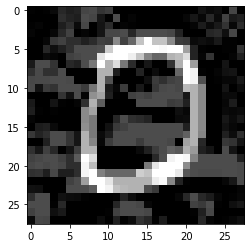

TGSM:
Test loss: 4.30
Successfully moved out of source class: 0.95
targeted_mode
Test loss: 0.35
Successfully perturbed to target class: 0.92
Mean perturbation distance: 0.17


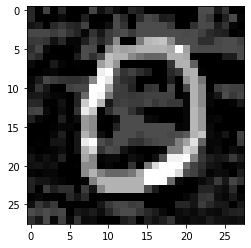

non targeted PGD:
Test loss: 2.60
Successfully moved out of source class: 0.74
Mean perturbation distance: 0.11


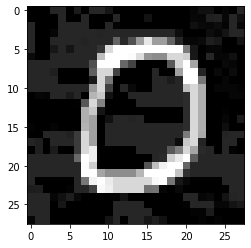

targeted PGD
Test loss: 1.06
Successfully moved out of source class: 0.36
targeted_mode
Test loss: 2.79
Successfully perturbed to target class: 0.32
Mean perturbation distance: 0.11


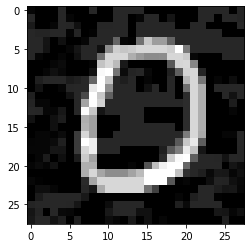

In [39]:
attack_model(model, test_images, test_labels, num_classes)

## Training and attacking - distilled model

In [48]:
train_temp = 30
dist_teacher_model, dist_student_model = defensive_distilation(num_classes, train_images, train_labels, test_images, test_labels, temp=train_temp)

Epoch 1/12
469/469 [==============================] - 23s 47ms/step - loss: 2.2508 - categorical_accuracy: 0.2320 - val_loss: 1.6336 - val_categorical_accuracy: 0.6878
Epoch 2/12
469/469 [==============================] - 23s 49ms/step - loss: 0.7947 - categorical_accuracy: 0.7503 - val_loss: 0.3604 - val_categorical_accuracy: 0.8991
Epoch 3/12
469/469 [==============================] - 23s 48ms/step - loss: 0.5320 - categorical_accuracy: 0.8331 - val_loss: 0.3016 - val_categorical_accuracy: 0.9121
Epoch 4/12
469/469 [==============================] - 22s 46ms/step - loss: 0.4786 - categorical_accuracy: 0.8501 - val_loss: 0.2704 - val_categorical_accuracy: 0.9220
Epoch 5/12
469/469 [==============================] - 21s 45ms/step - loss: 0.4417 - categorical_accuracy: 0.8642 - val_loss: 0.2511 - val_categorical_accuracy: 0.9261
Epoch 6/12
469/469 [==============================] - 22s 46ms/step - loss: 0.4184 - categorical_accuracy: 0.8706 - val_loss: 0.2348 - val_categorical_accuracy:

FGSM:
Test loss: 2.51
Successfully moved out of source class: 0.30
Mean perturbation distance: 0.05


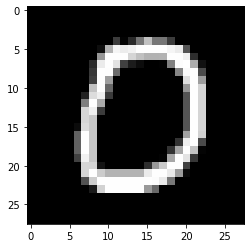

TGSM:
Test loss: 2.09
Successfully moved out of source class: 0.93
targeted_mode
Test loss: 1.23
Successfully perturbed to target class: 0.85
Mean perturbation distance: 0.14


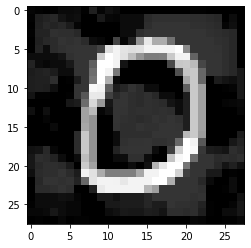

non targeted PGD:
Test loss: 1.48
Successfully moved out of source class: 0.29
Mean perturbation distance: 0.03


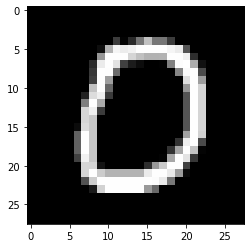

targeted PGD
Test loss: 1.17
Successfully moved out of source class: 0.45
targeted_mode
Test loss: 2.80
Successfully perturbed to target class: 0.39
Mean perturbation distance: 0.11


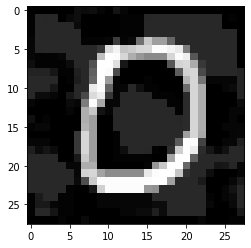

In [49]:
attack_model(dist_student_model, test_images, test_labels, num_classes)

## 2-class classifier

### Filtering data

In [88]:
filter_num_classes = 2
targets_selected = np.random.choice(num_classes, filter_num_classes)
print(targets_selected)

[9 4]


In [89]:
train_filtered_indices_boolean = (train_labels == keras.utils.to_categorical(targets_selected[0], num_classes)).all(axis=1) | (train_labels == keras.utils.to_categorical(targets_selected[1], num_classes)).all(axis=1)
test_filtered_indices_boolean = (test_labels == keras.utils.to_categorical(targets_selected[0], num_classes)).all(axis=1) | (test_labels == keras.utils.to_categorical(targets_selected[1], num_classes)).all(axis=1)

train_images_filtered = train_images[train_filtered_indices_boolean]
test_images_filtered = test_images[test_filtered_indices_boolean]

train_labels_filtered = train_labels[train_filtered_indices_boolean][:, targets_selected]
test_labels_filtered = test_labels[test_filtered_indices_boolean][:, targets_selected]

### training and attacking

In [90]:
non_distilled_model_2 = train_model(filter_num_classes, train_images_filtered, train_labels_filtered, test_images_filtered, test_labels_filtered)

Epoch 1/12
93/93 [==============================] - 4s 35ms/step - loss: 0.5293 - categorical_accuracy: 0.7699 - val_loss: 0.2801 - val_categorical_accuracy: 0.9211
Epoch 2/12
93/93 [==============================] - 3s 35ms/step - loss: 0.2318 - categorical_accuracy: 0.9209 - val_loss: 0.1200 - val_categorical_accuracy: 0.9663
Epoch 3/12
93/93 [==============================] - 3s 33ms/step - loss: 0.1520 - categorical_accuracy: 0.9468 - val_loss: 0.0905 - val_categorical_accuracy: 0.9724
Epoch 4/12
93/93 [==============================] - 3s 31ms/step - loss: 0.1250 - categorical_accuracy: 0.9569 - val_loss: 0.0716 - val_categorical_accuracy: 0.9764
Epoch 5/12
93/93 [==============================] - 3s 35ms/step - loss: 0.1089 - categorical_accuracy: 0.9624 - val_loss: 0.0616 - val_categorical_accuracy: 0.9779
Epoch 6/12
93/93 [==============================] - 3s 35ms/step - loss: 0.0997 - categorical_accuracy: 0.9653 - val_loss: 0.0540 - val_categorical_accuracy: 0.9814
Epoch 7/12

FGSM:
Test loss: 6.93
Successfully moved out of source class: 1.00
Mean perturbation distance: 0.16


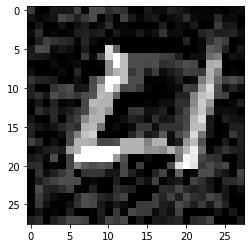

TGSM:
Test loss: 6.93
Successfully moved out of source class: 1.00
targeted_mode
Test loss: 0.01
Successfully perturbed to target class: 1.00
Mean perturbation distance: 0.16


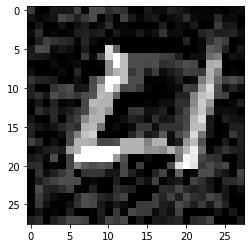

non targeted PGD:
Test loss: 2.34
Successfully moved out of source class: 0.77
Mean perturbation distance: 0.11


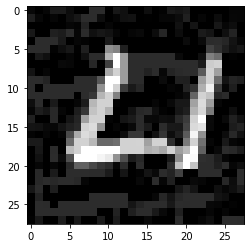

targeted PGD
Test loss: 2.34
Successfully moved out of source class: 0.77
targeted_mode
Test loss: 0.52
Successfully perturbed to target class: 0.77
Mean perturbation distance: 0.11


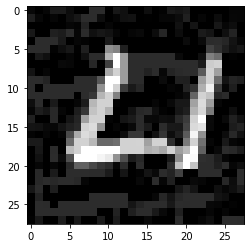

In [93]:
attack_model(non_distilled_model_2, test_images_filtered, test_labels_filtered, filter_num_classes)

In [91]:
dist_teacher_model_2, dist_student_model_2 = defensive_distilation(filter_num_classes, train_images_filtered, train_labels_filtered, test_images_filtered, test_labels_filtered, temp=train_temp)

Epoch 1/12
93/93 [==============================] - 3s 34ms/step - loss: 0.6926 - categorical_accuracy: 0.5375 - val_loss: 0.6916 - val_categorical_accuracy: 0.7328
Epoch 2/12
93/93 [==============================] - 3s 30ms/step - loss: 0.6906 - categorical_accuracy: 0.6349 - val_loss: 0.6885 - val_categorical_accuracy: 0.8302
Epoch 3/12
93/93 [==============================] - 3s 35ms/step - loss: 0.6857 - categorical_accuracy: 0.7088 - val_loss: 0.6791 - val_categorical_accuracy: 0.8468
Epoch 4/12
93/93 [==============================] - 3s 34ms/step - loss: 0.6643 - categorical_accuracy: 0.7703 - val_loss: 0.6292 - val_categorical_accuracy: 0.8438
Epoch 5/12
93/93 [==============================] - 3s 36ms/step - loss: 0.5488 - categorical_accuracy: 0.8104 - val_loss: 0.3964 - val_categorical_accuracy: 0.8800
Epoch 6/12
93/93 [==============================] - 4s 38ms/step - loss: 0.3506 - categorical_accuracy: 0.8691 - val_loss: 0.2299 - val_categorical_accuracy: 0.9206
Epoch 7/12

FGSM:
Test loss: 2.37
Successfully moved out of source class: 0.32
Mean perturbation distance: 0.06


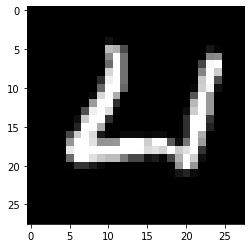

TGSM:
Test loss: 3.01
Successfully moved out of source class: 1.00
targeted_mode
Test loss: 0.05
Successfully perturbed to target class: 1.00
Mean perturbation distance: 0.11


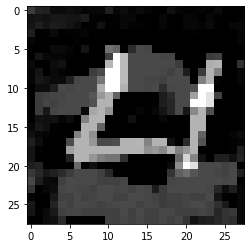

non targeted PGD:
Test loss: 1.29
Successfully moved out of source class: 0.32
Mean perturbation distance: 0.03


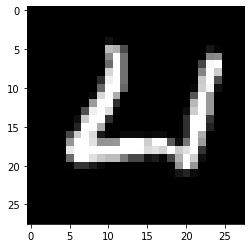

targeted PGD
Test loss: 2.26
Successfully moved out of source class: 0.86
targeted_mode
Test loss: 0.34
Successfully perturbed to target class: 0.86
Mean perturbation distance: 0.10


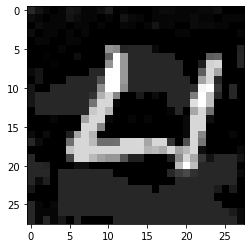

In [92]:
attack_model(dist_student_model_2, test_images_filtered, test_labels_filtered, filter_num_classes)

In [141]:
def visualize_analysis(model,  images, labels, title):
    logits = model(images)
    softmax = keras.activations.softmax(logits, axis=-1)
    print(logits.shape)
    print(softmax.shape)
    logits_range = max(abs(logits.numpy().min()), abs(logits.numpy().max()))
    logits_x = np.linspace(-logits_range, logits_range, 100)
    softmax_x = np.linspace(0, softmax.numpy().max(), 100)

    print(logits.shape)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle(title)
    ax1.scatter(logits[:, 0], logits[:, 1])
    ax1.plot(logits_x, logits_x, 'k--')
    ax1.plot(logits_x, -logits_x, 'k--')
    ax1.set_title('logits')
    ax1.set_xlabel('logit[0]')
    ax1.set_ylabel('logit[1]')
    
    ax2.scatter(softmax[:, 0], softmax[:, 1])
    ax2.plot(softmax_x, softmax_x, 'k--')
    ax2.set_title('softmax')
    ax2.set_xlabel('softmax[0]')
    ax2.set_ylabel('softmax[1]')

(5842, 2)
(5842, 2)
(5842, 2)


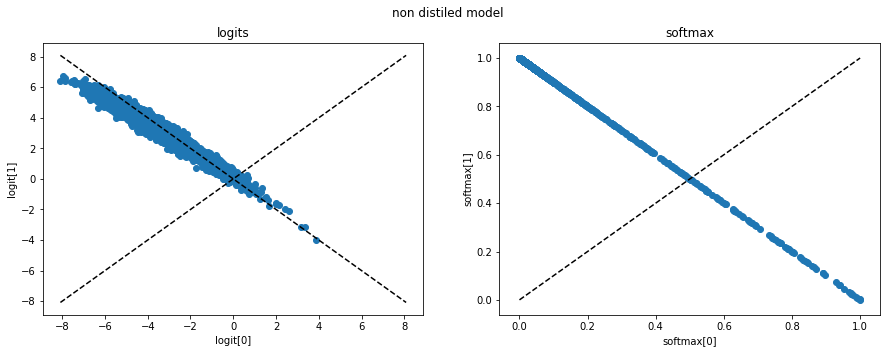

In [138]:
visualize_analysis(non_distilled_model_2, train_images_filtered[train_labels_filtered[:, 1]==1], train_labels_filtered[train_labels_filtered[:, 1]==1], title='non distiled model')

(5842, 2)
(5842, 2)
(5842, 2)


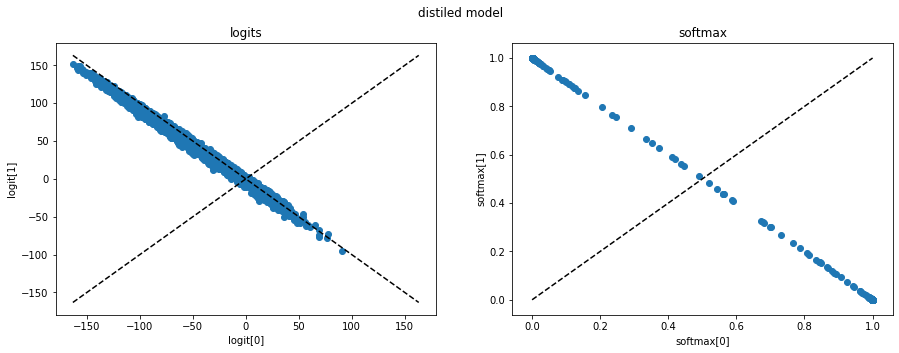

In [142]:
visualize_analysis(dist_student_model_2, train_images_filtered[train_labels_filtered[:, 1]==1], train_labels_filtered[train_labels_filtered[:, 1]==1], title='distiled model')